## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA

In [3]:
!pip install hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 7.0 MB/s eta 0:00:00


In [4]:
from bokeh.models import ColumnDataSource, Whisker
from bokeh.plotting import figure, show
from bokeh.sampledata.autompg2 import autompg2 as df
from bokeh.transform import factor_cmap, jitter
import holoviews as hv

In [5]:
import hvplot.pandas
import hvplot.dask  # noqa

## Dataset Loading

In [6]:
# Load the data
column_dict = pd.read_csv('/kaggle/input/data-science-challenge-predicting-stock-trends/column_names_dictionary.csv', delimiter=';')
df_train = pd.read_csv('/kaggle/input/data-science-challenge-predicting-stock-trends/training_data.csv', delimiter=';', keep_default_na=False, na_values=["NA"])
df_test = pd.read_csv('/kaggle/input/data-science-challenge-predicting-stock-trends/test_data_no_target.csv', delimiter=';', keep_default_na=False, na_values=["NA"])
group_dict = pd.read_csv('/kaggle/input/data-science-challenge-predicting-stock-trends/group_dictionary.csv', delimiter=';')

# replacing commas on floating points
df_raw_train = df_train.replace(',', '.', regex=True)
df_raw_test = df_test.replace(',', '.', regex=True)

pd.set_option('display.max_columns',None) # display all the columns

In [7]:
column_dict.hvplot.table(columns=['CODE', 'INDEX', 'INDICATOR NAME'], sortable=True, selectable=True)

:Table   [CODE,INDEX,INDICATOR NAME]

In [8]:
group_dict.hvplot.table(columns=['CODE', 'NUM', 'SECTOR'], sortable=True, selectable=True)

:Table   [CODE,NUM,SECTOR]

## Dataset Preprocessing

In [9]:
col_names = ['Group']+list(column_dict['INDICATOR NAME'][1:])+['Class', 'Perform']
col_codes = ['Group']+list(column_dict['CODE'][1:])+['Class', 'Perform']

df_train_ind = pd.DataFrame(df_train.to_numpy(), columns=col_names)
df_test_ind = pd.DataFrame(df_test.to_numpy(), columns=col_names[:-2])

In [10]:
col_dict = dict(zip(col_codes, col_names))

In [49]:
# replacing commas on floating points
df_train_ind = df_train_ind.replace(',', '.', regex=True)
df_train = df_train.replace(',', '.', regex=True)
df_test = df_test.replace(',', '.', regex=True)

/tmp/ipykernel_33/1851041686.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_ind = df_train_ind.replace(',', '.', regex=True)


In [11]:
group_to_sector = {
    'G1': 'Communication Services',
    'G2': 'Consumer Discretionary',
    'G3': 'Consumer Staples',
    'G4': 'Energy',
    'G5': 'Financials',
    'G6': 'Health Care',
    'G7': 'Industrials',
    'G8': 'Information Technology',
    'G9': 'Materials',
    'G10': 'Real Estate',
    'G11': 'Utilities'
}

df_train_ind['Sector'] = df_train_ind['Group'].map(group_to_sector)
df_train['Sector'] = df_train['Group'].map(group_to_sector)

In [12]:
df_test['Sector'] = df_test['Group'].map(group_to_sector)
df_test_ind['Sector'] = df_test_ind['Group'].map(group_to_sector)

In [13]:
df_train['Sector'].value_counts().hvplot.bar(title='Group distribution', xlabel='Group', ylabel='Count', rot=45, width=800, height=500)

:Bars   [Sector]   (count)

In [14]:
df_test['Sector'].value_counts().hvplot.bar(title='Group distribution for Test Set', xlabel='Group', ylabel='Count', rot=45, width=800, height=500, color='coral')

:Bars   [Sector]   (count)

## Checking missing values

In [15]:
# Counting empty values and N/A values

print('Train Set \n')
count_of_NA_string = df_train.isin(['NA']).sum().sum()
print('count_of_NA_string:', count_of_NA_string)

count_of_empty_string_train = df_train.isin(['']).sum().sum()
print('count_of_empty_string:', count_of_empty_string_train)

count_of_NaN_train = df_train.isna().sum().sum()
print('count_of_NaN:', count_of_NaN_train)

print('')
print('Test Set \n')
count_of_NA_string = df_test.isin(['NA']).sum().sum()
print('count_of_NA_string:', count_of_NA_string)

count_of_empty_string_test = df_test.isin(['']).sum().sum()
print('count_of_empty_string:', count_of_empty_string_test)

count_of_NaN_test = df_test.isna().sum().sum()
print('count_of_NaN:', count_of_NaN_test)

Train Set 

count_of_NA_string: 0
count_of_empty_string: 2759
count_of_NaN: 26174

Test Set 

count_of_NA_string: 0
count_of_empty_string: 690
count_of_NaN: 6094


## Missing values across each columns

In [16]:
# Check counts of 'Non-Applicable' which replaced empty strings
not_applicable_count = (df_train == '').sum()

# Check the remaining NaNs if any
NA_count = df_train.isna().sum()

print("Counts of 'Non-Applicable':\n", not_applicable_count.sort_values(ascending=False)[:20])
print("Remaining NA values:\n", NA_count.sort_values(ascending=False)[:20])

Counts of 'Non-Applicable':
 dI44    458
dI13    439
dI43    214
dI58    210
I44     150
I13     145
I58     143
dI29     80
dI18     80
dI17     78
dI38     76
I18      69
dI28     62
I28      59
I55      49
dI24     44
dI12     33
dI55     30
I24      29
I17      27
dtype: int64
Remaining NA values:
 I21     1549
dI21    1549
dI50    1549
dI48    1549
I50     1520
I48     1520
dI24     713
I24      701
dI14     671
I14      671
dI26     535
dI27     523
dI4      523
I52      523
I51      523
dI45     523
dI46     523
I45      523
I27      523
I26      523
dtype: int64


In [17]:
# Check counts of 'Non-Applicable' which replaced empty strings
not_applicable_count = (df_train_ind == '').sum()

# Check the remaining NaNs if any
NA_count = df_train_ind.isna().sum()

print("Counts of 'Non-Applicable':\n", not_applicable_count.sort_values(ascending=False)[:20])
print("Remaining NA values:\n", NA_count.sort_values(ascending=False)[:20])

Counts of 'Non-Applicable':
 1-year Absolute Change of PE Growth Ratio, TTM                                          458
1-year Absolute Change of Dividend Payout Ratio - %, TTM                                439
1-year Absolute Change of Dividend Yield - Common - Net - Issue - %, TTM                214
1-year Absolute Change of Price to Cash Flow from Operations per Share, TTM             210
PE Growth Ratio, TTM                                                                    150
Dividend Payout Ratio - %, TTM                                                          145
Price to Cash Flow from Operations per Share, TTM                                       143
1-year Absolute Change of Enterprise Value to EBIT, TTM                                  80
1-year Absolute Change of FCF Net of Dividends Pct of Debt, Pref Eq & Min Intr, TTM      80
1-year Absolute Change of Debt - Total to EBITDA, TTM                                    78
1-year Absolute Change of Price to Cash Flow per Sh

##### We can see that there are similar number of missing values across some columns. Let's see if the missing values correlation to each other or not. We can check them using a library called msno. They have two functions 'matrix' and 'heatmap'. 

<Axes: >

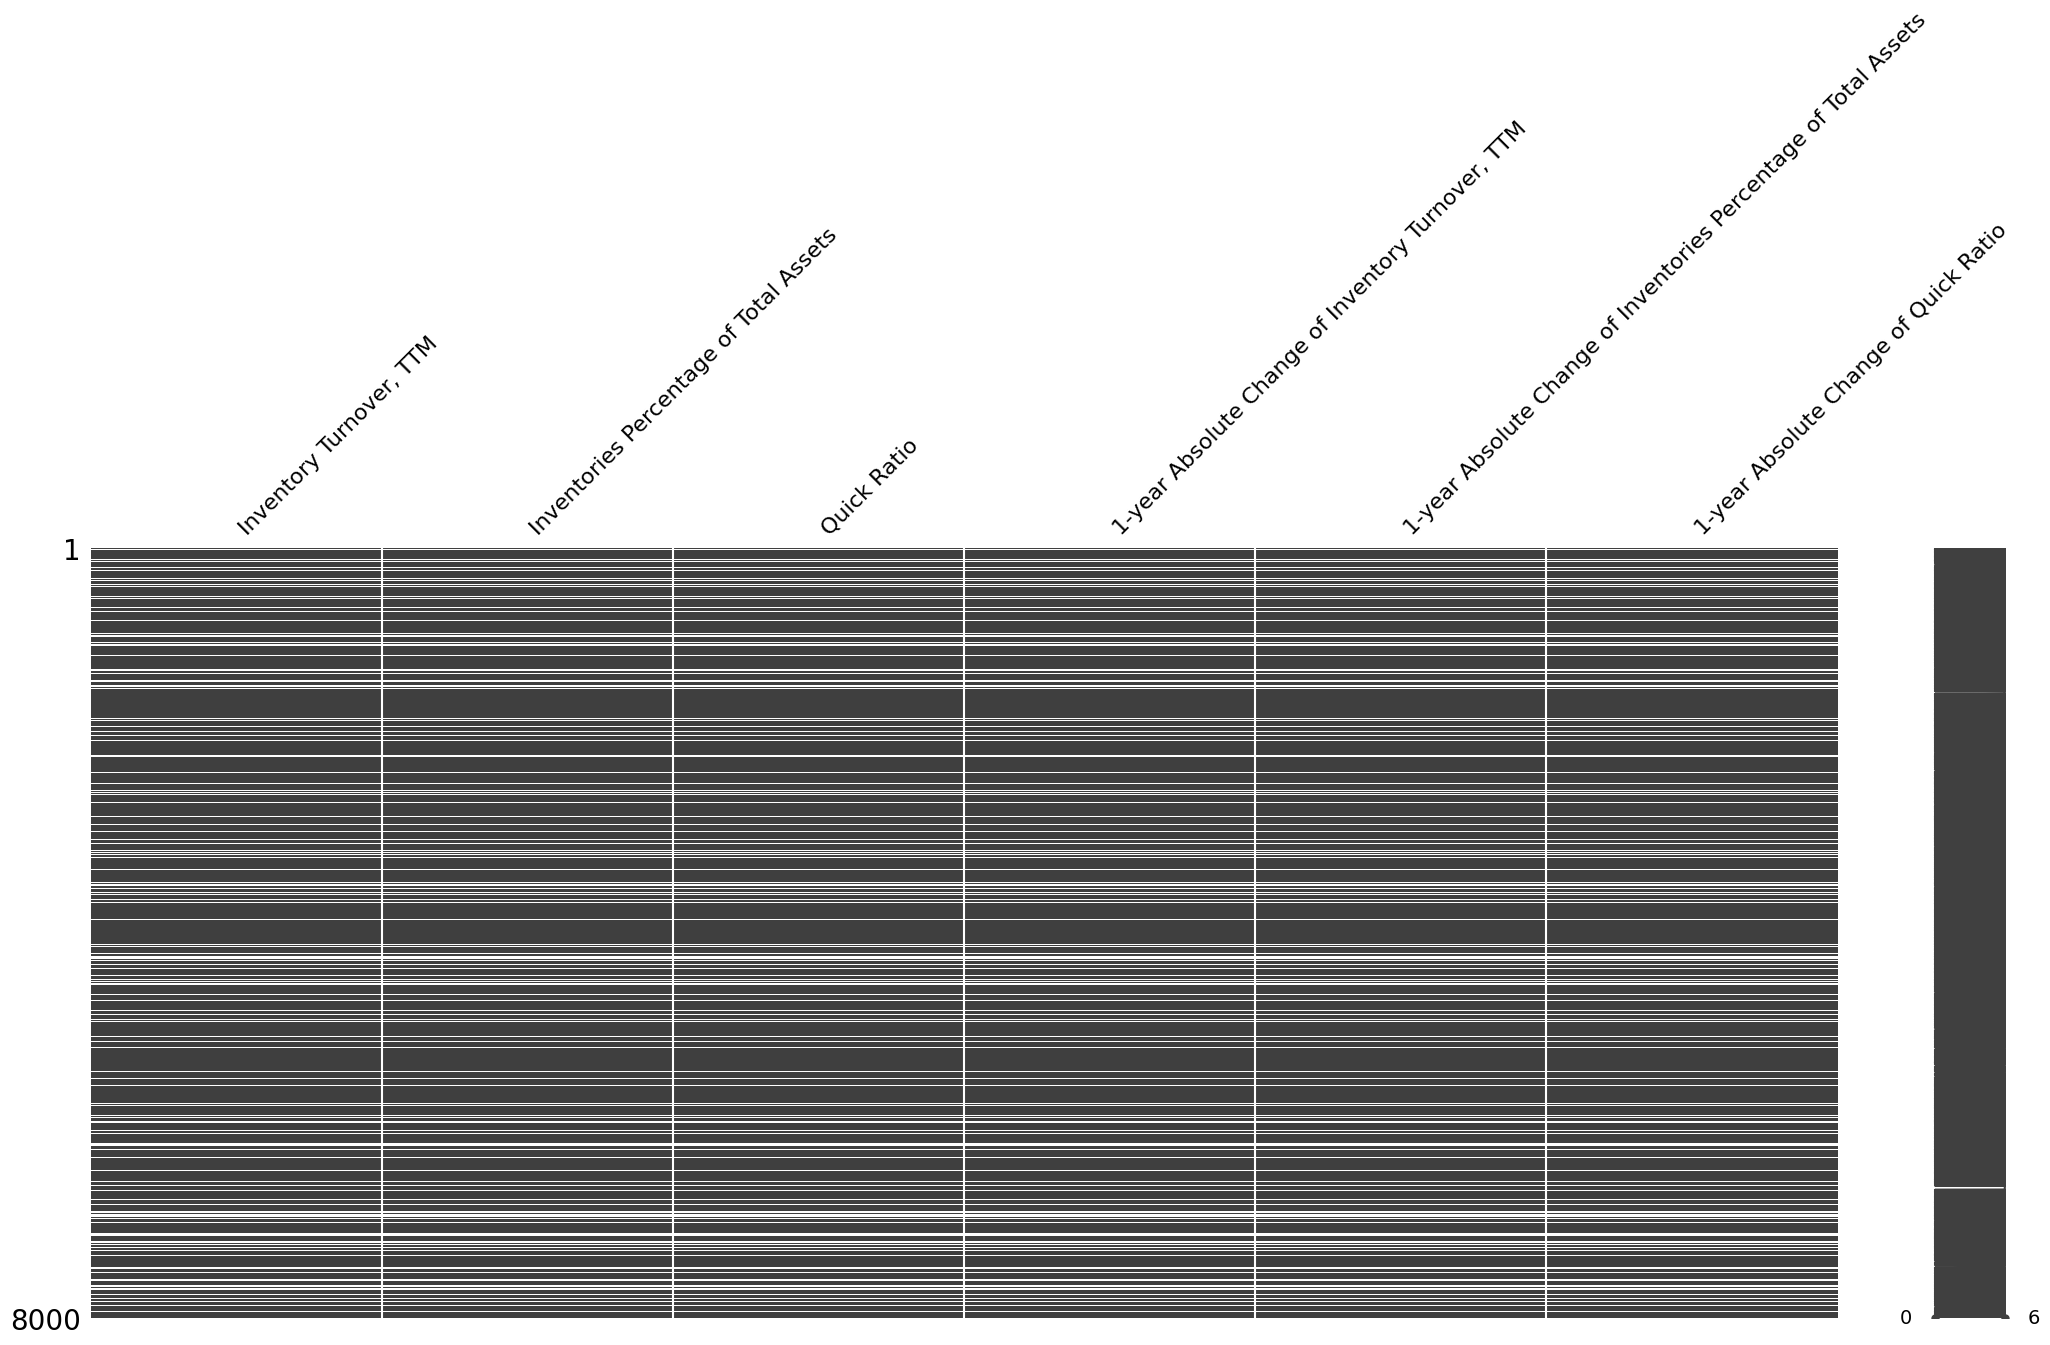

In [18]:
missing_c1 = ['Inventory Turnover, TTM',
     'Inventories Percentage of Total Assets',
     'Quick Ratio',
     '1-year Absolute Change of Inventory Turnover, TTM',
     '1-year Absolute Change of Inventories Percentage of Total Assets',
     '1-year Absolute Change of Quick Ratio']

msno.matrix(df_train_ind[missing_c1])

The white horizonal bars represent missing values. We can see long horizontal lines across all the columns. This means the missing values are definitely correlated. Check see it using heatmap.

In [ ]:
msno.heatmap(df_train_ind[missing_c1])

<Axes: >

The correlation is almost 1. Which confirms our assumption. 

Let's check for the rest of the columns.

In [ ]:
missing_c2 = list(dict(NA_count.sort_values(ascending=False)[6:20]).keys())

In [ ]:
msno.heatmap(df_train_ind[missing_c2])

<Axes: >

##### It's clearly visible a lot of the columns have highcorrelation of missing values. Now let's check what is the % of missing values across these columns.

In [ ]:
na_counts = pd.Series({
    'dI44': 458, 'dI13': 439, 'dI43': 214, 'dI58': 210, 'I44': 150,
    'I13': 145, 'I58': 143, 'dI29': 80, 'dI18': 80, 'dI17': 78,
    'dI38': 76, 'I18': 69, 'dI28': 62, 'I28': 59, 'I55': 49,
    'dI24': 44, 'dI12': 33, 'dI55': 30, 'I24': 29, 'I17': 27
})

na_remaining = pd.Series({
    'I21': 1549, 'dI21': 1549, 'dI50': 1549, 'dI48': 1549, 'I50': 1520,
    'I48': 1520, 'dI24': 713, 'I24': 701, 'dI14': 671, 'I14': 671,
    'dI26': 535, 'dI27': 523, 'dI4': 523, 'I52': 523, 'I51': 523,
    'dI45': 523, 'dI46': 523, 'I45': 523, 'I27': 523, 'I26': 523
})

# Convert Series to DataFrame
na_counts_df = na_counts.to_frame(name='Non-Applicable Count')
na_remaining_df = na_remaining.to_frame(name='NA Count')

# Assuming the total number of entries for percentage calculation
total_entries = 8000  # You should adjust this to reflect your actual data size

# Calculate percentages
na_counts_df['Non-Applicable Percentage'] = (na_counts_df['Non-Applicable Count'] / total_entries) * 100
na_remaining_df['NA Percentage'] = (na_remaining_df['NA Count'] / total_entries) * 100

In [ ]:
na_counts_ind = []
for col in na_counts.keys():
    if col in col_dict.keys():
        na_counts_ind.append(col_dict[col])

na_remaining_ind = []
for col in na_remaining.keys():
    if col in col_dict.keys():
        na_remaining_ind.append(col_dict[col])

In [ ]:
# Reset the index to make the current index a column
na_remaining_df = na_remaining_df.reset_index()
# Rename the 'index' column
na_remaining_df.rename(columns={'index': 'Indicator'}, inplace=True)
# na_remaining_df.head()

na_counts_df = na_counts_df.reset_index()
na_counts_df.rename(columns={'index': 'Indicator'}, inplace=True)
# na_counts_df.head()

In [ ]:
na_remaining_df['Indicator Names'] = na_remaining_ind
na_counts_df['Indicator Names'] = na_counts_ind

In [ ]:
# reorder columns
na_remaining_df = na_remaining_df[['Indicator', 'Indicator Names', 'NA Count', 'NA Percentage']]
na_counts_df = na_counts_df[['Indicator', 'Indicator Names', 'Non-Applicable Count', 'Non-Applicable Percentage']]

In [ ]:
# Create HoloViews tables
na_counts_df.hvplot.table(label='Non-Applicable Values', sortable=True, selectable=True, width=800, height=500)

:Table   [Indicator,Indicator Names,Non-Applicable Count,Non-Applicable Percentage]

In [ ]:
na_remaining_df.hvplot.table(label='Remaining NA Values', sortable=True, selectable=True, width=800, height=500)

:Table   [Indicator,Indicator Names,NA Count,NA Percentage]

Some of the columns have almost 20% missing values which is alot. We might need to drop them. 

## Checking Missing values across all the sectors

In [ ]:
# Check missing values across all the "Sector" columns by dividing the data into sectors

# Group the data by 'Sector' column
sector_groups = df_train.groupby('Sector')

# Create a dictionary to store the missing values for each sector
sector_na_counts = {}

# Loop through each sector and calculate the missing values and add indicator column

for sector, data in sector_groups:
    # Calculate the missing values for each sector
    sector_na_counts[sector] = data.isna().sum()

sector_na_counts['Indicators'] = df_train.columns
sector_na_counts['Indicator Names'] = df_train_ind.columns
# Convert the dictionary to a DataFrame and include Indicator column

sector_na_df = pd.DataFrame(sector_na_counts)

In [ ]:
# Display the DataFrame using HoloViews
sector_na_df.hvplot.table(width=1000, height=500, title='Missing Values by Sector')

:Table   [Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities,Indicators,Indicator Names]

That's a great insight. We can clearly see that 'Communication Services' contain most of the missing values. Let's see the percentage.

In [31]:
# Calculate total missing values and their percentage for each sector

# Create a dictionary to store the total missing values and percentage for each sector

sector_na_totals = {}

# Loop through each sector and calculate the total missing values and percentage

for sector, data in sector_groups:
    # Calculate the total missing values for each sector
    sector_na_totals[sector] = data.isna().sum().sum()

# Convert the dictionary to a DataFrame and include Indicator column

sector_na_totals_df = pd.DataFrame(sector_na_totals, index=['Total Missing Values']).T

# Calculate the percentage of missing values for each sector
sector_na_totals_df['Percentage'] = (sector_na_totals_df['Total Missing Values'] / 26174) * 100
sector_na_totals_df['Sector Names'] = sector_na_totals_df.index

# Display the DataFrame using HoloViews
sector_na_totals_df.hvplot.table(width=500, height=400, title='Total Missing Values by Sector')

:Table   [Total Missing Values,Percentage,Sector Names]

Over 75%! So a single group contains most of our missing values. This looks interesting. This group has 880 samples. So for some columns there is not a single values in the whole column. 

##### Let's see if these patterns are in the test set as well.

In [32]:
# Check counts of 'Non-Applicable' which replaced empty strings
not_applicable_count_test = (df_test == '').sum()

# Check the remaining NaNs if any
NA_count_test = df_test.isna().sum()

print("Counts of 'Non-Applicable':\n", not_applicable_count_test.sort_values(ascending=False)[:20])
print("Remaining NA values:\n", NA_count_test.sort_values(ascending=False)[:20])

Counts of 'Non-Applicable':
 dI44    106
dI13    105
dI43     67
dI58     52
I44      45
I13      44
I58      37
dI17     20
I18      18
dI18     18
dI24     17
dI38     16
dI29     13
I24      12
I55      11
I28      10
dI56      9
I17       8
dI28      8
I56       8
dtype: int64
Remaining NA values:
 I21     367
dI48    367
dI21    367
dI50    367
I50     361
I48     361
dI24    169
I24     166
I14     155
dI14    155
dI26    122
dI4     119
dI27    119
I45     119
I46     119
dI45    119
dI46    119
I27     119
I52     119
I49     119
dtype: int64


In [33]:
# Dictionary for 'Counts of Non-Applicable'
na_counts_test = pd.Series({
    'dI44': 106, 'dI13': 105, 'dI43': 67, 'dI58': 52,
    'I44': 45, 'I13': 44, 'I58': 37, 'dI17': 20,
    'dI18': 18, 'I18': 18, 'dI24': 17, 'dI38': 16,
    'dI29': 13, 'I24': 12, 'I55': 11, 'I28': 10,
    'dI56': 9, 'dI28': 8, 'I17': 8, 'I56': 8
})
# Dictionary for 'Remaining NA values'
na_remaining_test = pd.Series({
    'dI21': 367, 'dI50': 367, 'dI48': 367, 'I21': 367,
    'I48': 361, 'I50': 361, 'dI24': 169, 'I24': 166,
    'dI14': 155, 'I14': 155, 'dI26': 122, 'I26': 119,
    'I27': 119, 'dI27': 119, 'dI15': 119, 'dI4': 119,
    'I52': 119, 'I45': 119, 'I46': 119, 'I51': 119
})

# make list of indicator names
na_counts_ind_test = []
for col in na_counts_test.keys():
    if col in col_dict.keys():
        na_counts_ind_test.append(col_dict[col])

na_remaining_ind_test = []
for col in na_remaining_test.keys():
    if col in col_dict.keys():
        na_remaining_ind_test.append(col_dict[col])

# Convert Series to DataFrame
na_counts_df_test = na_counts_test.to_frame(name='Non-Applicable Count')
na_remaining_df_test = na_remaining_test.to_frame(name='NA Count')

# Assuming the total number of entries for percentage calculation
total_entries = 2000  # You should adjust this to reflect your actual data size

# Calculate percentages
na_counts_df_test['Non-Applicable Percentage'] = (na_counts_df_test['Non-Applicable Count'] / total_entries) * 100
na_remaining_df_test['NA Percentage'] = (na_remaining_df_test['NA Count'] / total_entries) * 100

In [34]:
# Reset the index to make the current index a column
na_remaining_df_test = na_remaining_df_test.reset_index()
# Rename the 'index' column
na_remaining_df_test.rename(columns={'index': 'Indicator'}, inplace=True)
# na_remaining_df.head()

na_counts_df_test = na_counts_df_test.reset_index()
na_counts_df_test.rename(columns={'index': 'Indicator'}, inplace=True)
# na_counts_df.head()

In [35]:
na_remaining_df_test['Indicator Names'] = na_remaining_ind_test
na_counts_df_test['Indicator Names'] = na_counts_ind_test

In [36]:
# reorder columns
na_remaining_df_test = na_remaining_df_test[['Indicator', 'Indicator Names', 'NA Count', 'NA Percentage']]
na_counts_df_test = na_counts_df_test[['Indicator', 'Indicator Names', 'Non-Applicable Count', 'Non-Applicable Percentage']]

In [37]:
na_counts_df_test.hvplot.table(label='Non-Applicable Values in Test Set', sortable=True, selectable=True, width=800, height=500)

:Table   [Indicator,Indicator Names,Non-Applicable Count,Non-Applicable Percentage]

In [38]:
na_remaining_df_test.hvplot.table(label='Remaining NA Values in Test Set', sortable=True, selectable=True, width=800, height=500)

:Table   [Indicator,Indicator Names,NA Count,NA Percentage]

In [39]:
# Check missing values across all the "Sector" columns by dividing the data into sectors for test set

# Group the data by 'Sector' column
sector_groups_test = df_test.groupby('Sector')

# Create a dictionary to store the missing values for each sector
sector_na_counts_test = {}

# Loop through each sector and calculate the missing values and add indicator column

for sector, data in sector_groups_test:
    # Calculate the missing values for each sector
    sector_na_counts_test[sector] = data.isna().sum()

sector_na_counts_test['Indicators'] = df_test.columns
sector_na_counts_test['Indicator Names'] = df_test.columns

# Convert the dictionary to a DataFrame and include Indicator column

sector_na_df_test = pd.DataFrame(sector_na_counts_test)

In [43]:
# Calculate total missing values and their percentage for each sector

# Create a dictionary to store the total missing values and percentage for each sector

sector_na_totals_test = {}

# Loop through each sector and calculate the total missing values and percentage

for sector, data in sector_groups_test:
    # Calculate the total missing values for each sector
    sector_na_totals_test[sector] = data.isna().sum().sum()

# Convert the dictionary to a DataFrame and include Indicator column

sector_na_totals_test_df = pd.DataFrame(sector_na_totals_test, index=['Total Missing Values']).T

# Calculate the percentage of missing values for each sector
sector_na_totals_test_df['Percentage'] = (sector_na_totals_test_df['Total Missing Values'] / 6094) * 100
sector_na_totals_test_df['Sector Names'] = sector_na_totals_test_df.index

# Display the DataFrame using HoloViews
sector_na_totals_test_df.hvplot.table(width=500, height=400, title='Total Missing Values by Sector')

:Table   [Total Missing Values,Percentage,Sector Names]

##### We can confirm that there is a very close similarity in the distibution of missing values across different sectors of test set as well and 'Communication Services' dominates again.

## Handling Empty Strings

We can deduce that not applicable or empty strings should not be imputed with any values. So we can make replace them with 0.

In [46]:
# List of columns where 'Non-Applicable' should be replaced with 0
columns_to_zero = []

# Iterate over the columns
for column in df_train.columns:
    # Check if the column contains 'Non-Applicable'
    if '' in df_train[column].values:
        # Append the column to the list
        columns_to_zero.append(column)

print(len(columns_to_zero))

# Replace 'Non-Applicable' with 0 in the specified columns
df_train[columns_to_zero] = df_train[columns_to_zero].replace('', 0)

58


In [47]:
columns_to_zero = []

# Iterate over the columns
for column in df_test.columns:
    # Check if the column contains 'Non-Applicable'
    if '' in df_test[column].values:
        # Append the column to the list
        columns_to_zero.append(column)

print(len(columns_to_zero))

# Replace 'Non-Applicable' with 0 in the specified columns
df_test[columns_to_zero] = df_test[columns_to_zero].replace('', 0)

47


## Correlation

In [45]:
# checking for each data type

# Create an empty dictionary to store the counts for each data type
type_counts = {}

# Iterate through each column and update the counts for each data type
for column in df_train.columns:
    data_type = df_train[column].dtype
    if data_type in type_counts:
        type_counts[data_type] += 1
    else:
        type_counts[data_type] = 1

# Print out the counts for each data type
for data_type, count in type_counts.items():
    print(f"Data type '{data_type}' has {count} columns.")

Data type 'object' has 119 columns.
Data type 'int64' has 1 columns.


### Checking correlation between indicator and their derivatives

In [50]:
# converting object to float data type

# changing data types to float
df_train = pd.concat([df_train.iloc[:,0], df_train[df_train.columns[1:-1]].astype(float)], axis=1)
df_test = pd.concat([df_test.iloc[:,0], df_test[df_test.columns[1:-1]].astype(float)], axis=1)

In [56]:
# Visualize correlation between features and target variable

# Calculate the correlation matrix between I and their dI indicators

# Create a list to store the correlation values

correlation_values = []

# Iterate through the columns and calculate the correlation values

for i in range(1, 59):
    # Calculate the correlation between the I and dI indicators
    correlation = df_train[f'I{i}'].corr(df_train[f'dI{i}'])
    # Append the correlation value to the list
    correlation_values.append(correlation)

# Create a DataFrame to store the correlation values
correlation_df = pd.DataFrame(correlation_values, index=[f'I{i}' for i in range(1, 59)], columns=['Correlation'])

# Display the DataFrame using HoloViews
correlation_df.hvplot.bar(title='Correlation between I and dI Indicators', xlabel='Indicator Names', ylabel='Correlation', rot=45, width=1000, height=500, color='pink')

:Bars   [index]   (Correlation)

### Checking correlation between I and class

In [59]:
# Check correlation between each I and and target variable 'Class'

# Create a list to store the correlation values

correlation_values = []

# Iterate through the columns and calculate the correlation values

for i in range(1, 59):
    # Calculate the correlation between the I and dI indicators
    correlation = df_train[f'I{i}'].corr(df_train['Class'])
    # Append the correlation value to the list
    correlation_values.append(correlation)

# Create a DataFrame to store the correlation values
correlation_df1 = pd.DataFrame(correlation_values, index=[f'I{i}' for i in range(1, 59)], columns=['Correlation'])

# Display the DataFrame using HoloViews
correlation_df1.hvplot.bar(title='Correlation between I Indicators and Class', xlabel='Indicator Names', ylabel='Correlation', rot=45, width=1000, height=500, color='violet')

:Bars   [index]   (Correlation)

### Correlation between dI and Class

In [58]:
# Check correlation between each dI and and target variable 'Class'

# Create a list to store the correlation values

correlation_values = []

# Iterate through the columns and calculate the correlation values

for i in range(1, 59):
    # Calculate the correlation between the I and dI indicators
    correlation = df_train[f'dI{i}'].corr(df_train['Class'])
    # Appaend the correlation value to the list
    correlation_values.append(correlation)

# Create a DataFrame to store the correlation values
correlation_df2 = pd.DataFrame(correlation_values, index=[f'dI{i}' for i in range(1, 59)], columns=['Correlation'])

# Display the DataFrame using HoloViews
correlation_df2.hvplot.bar(title='Correlation between dI Indicators and Class', xlabel='Indicator Names', ylabel='Correlation', rot=45, width=1000, height=500, color='cyan')



:Bars   [index]   (Correlation)

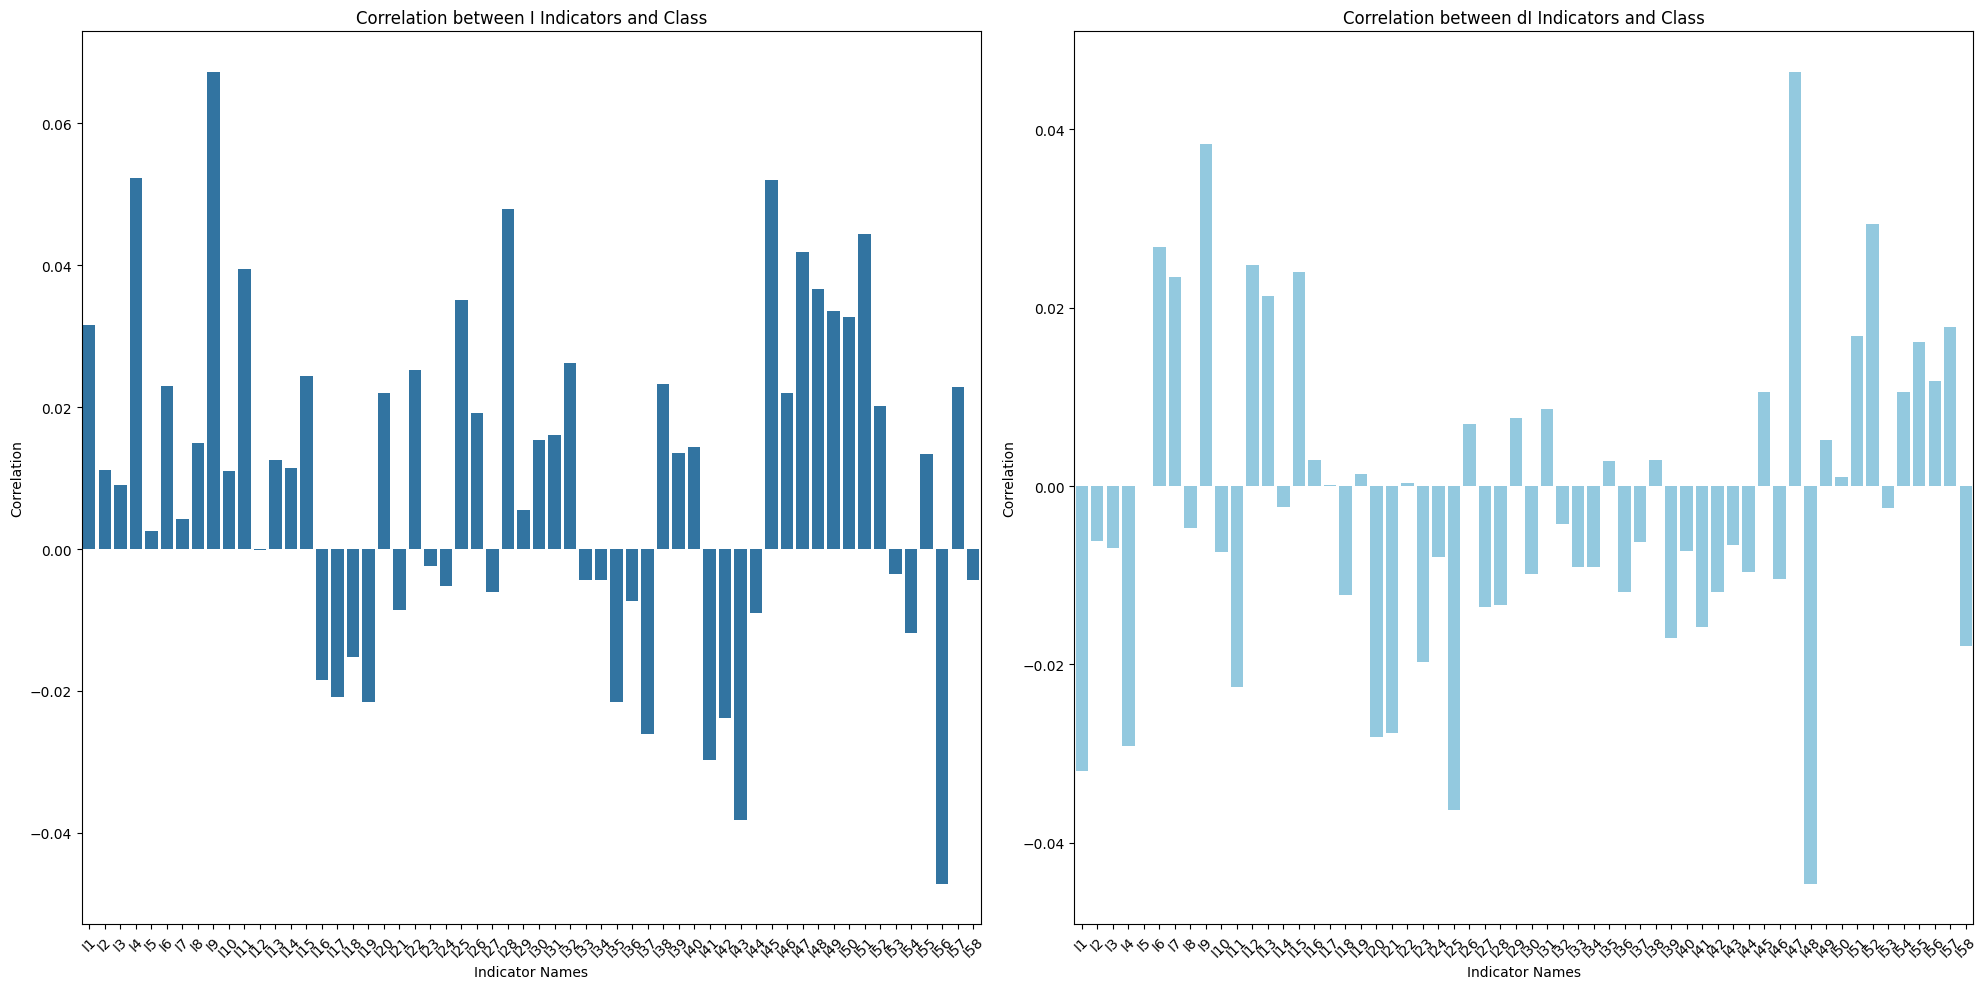

In [60]:
# Create the 2 plots on the same figure using Seaborn
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x=correlation_df1.index, y='Correlation', data=correlation_df1, color='tab:blue')
plt.title('Correlation between I Indicators and Class')
plt.xlabel('Indicator Names')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x=correlation_df.index, y='Correlation', data=correlation_df2, color='skyblue')
plt.title('Correlation between dI Indicators and Class')
plt.xlabel('Indicator Names')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
